In [1]:
import healpy as hp
import healpy.fitsfunc as fitsfunc
import healpy.pixelfunc as pixelfunc
from matplotlib import pyplot as plt
import numpy as np
DirPath    = '/Users/inchanji/Research/sze/data/'
CMBMapFile = 'HFI_SkyMap_143_2048_R2.02_full.fits'
YMapFile   = 'COM_CompMap_Compton-SZMap-milca-ymaps_2048_R2.00.fits'
YMapMaskFile   = 'COM_CompMap_Compton-SZMap-masks_2048_R2.00.fits'

GalMapFile = 'HFI_Mask_GalPlane-apo5_2048_R2.00.fits'
PtMapFile  = 'HFI_Mask_PointSrc_2048_R2.00.fits'

LBCGcatalog = 'LBCGs.cat'
NSIDE = 2048;
dtheta = dphi = 0.0012 # 4 arcmin in radian

In [2]:
def pick_random_indice(index = [], num=0, scheme = 1):
    if num == 0: return index
    ind = np.array([0],dtype='i4')
    j = 1l
    Ntot = np.size(index)
    while j < num:
        i = int(np.random.uniform(1, Ntot-1l))
        cnt = ind == i
        if (np.sum(cnt) == 0):
            ind = np.concatenate((ind, np.array([i],dtype='i4')))
            j += 1
    if scheme:
        return index[ind]
    else: 
        return ind

In [3]:
Ntot = sum(1 for line in open(DirPath+LBCGcatalog)) - 8
print Ntot
DataTable = np.array([line.rstrip('\n') for line in open(DirPath+LBCGcatalog)])[8:]

class Catalog:
    RA = []; DEC = []; Z = []; MAGs = []; B300 = []; B1000 =[]; 
    MASS = []; O2EW = []; O2EWERR =[]; O2VMEAS = []; O2VMERR =[];
    theta = []; phi = []; Rmag = []; # radian
    for i in range(Ntot):
        RA.append(float(DataTable[i].split('\t')[2]))
        DEC.append(float(DataTable[i].split('\t')[3]))
        Z.append(float(DataTable[i].split('\t')[4]))
        MAGs.append( [ float(DataTable[i].split('\t')[5+j]) for j in range(7) ])
        Rmag.append(float(DataTable[i].split('\t')[9]))
        B300.append(float( DataTable[i].split('\t')[12] ) )
        B1000.append(float( DataTable[i].split('\t')[13] ) )  
        MASS.append(float( DataTable[i].split('\t')[14] ) )   
        O2EW.append(float( DataTable[i].split('\t')[15] ) )   
        O2EWERR.append(float( DataTable[i].split('\t')[16] ) )        
        O2VMEAS.append(float( DataTable[i].split('\t')[17] ) )                
        O2VMERR.append(float( DataTable[i].split('\t')[18] ) )  
        theta.append( (90. - DEC[i])  * np.pi / 180.)
        phi.append( RA[i] * np.pi / 180.)
        
    RA  = np.array(RA); DEC = np.array(DEC); Z   = np.array(Z); MAGs = np.array(MAGs);
    B300 = np.array(B300); B1000 = np.array(B1000); MASS = np.array(MASS);
    O2EW = np.array(O2EW); O2EWERR = np.array(O2EWERR); O2VMEAS = np.array(O2VMEAS);
    O2VMERR = np.array(O2VMERR); theta = np.array(theta); phi = np.array(phi)
    Rmag = np.array(Rmag)


118188


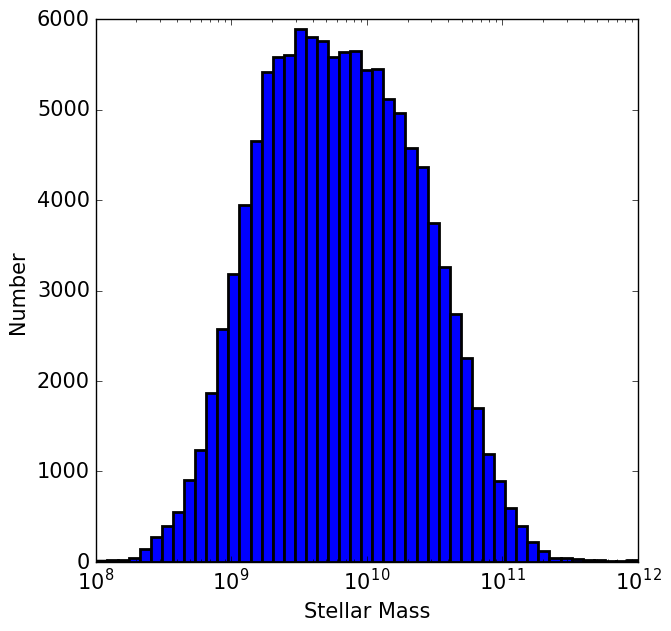

"\nNfig += 1 \n\nval = Catalog.theta\n\nlabel  = ''\n\nminval = 0.; maxval = np.max(val)\n#deln = (maxval - minval) / 20\n\nNfig += 1 \nax = plt.figure(Nfig, figsize=(7,7))\nplt.hist(val, ls='solid', edgecolor='black', log=False,     color='blue',linewidth=2,fill=True,label=label)\nplt.tick_params(axis='both', labelsize=15)#,  labelleft='off', labelright='on')\nplt.xlabel('', size = 15)\nplt.ylabel('Number ', size = 15)\n#plt.xscale('log')\nplt.show()\n\n"

In [4]:
Nfig = 0
Nfig += 1 

val = Catalog.MASS

label  = ''

minval = 1e8; maxval = 1e12
#deln = (maxval - minval) / 20

Nfig += 1 
ax = plt.figure(Nfig, figsize=(7,7))
plt.hist(val, ls='solid', edgecolor='black', log=False, bins=np.logspace(8, 12, 50), \
    color='blue',linewidth=2,fill=True,label=label)
plt.tick_params(axis='both', labelsize=15)#,  labelleft='off', labelright='on')
plt.xlabel('Stellar Mass', size = 15)
plt.ylabel('Number ', size = 15)
plt.xscale('log')
plt.show()



'''
Nfig += 1 

val = Catalog.theta

label  = ''

minval = 0.; maxval = np.max(val)
#deln = (maxval - minval) / 20

Nfig += 1 
ax = plt.figure(Nfig, figsize=(7,7))
plt.hist(val, ls='solid', edgecolor='black', log=False, \
    color='blue',linewidth=2,fill=True,label=label)
plt.tick_params(axis='both', labelsize=15)#,  labelleft='off', labelright='on')
plt.xlabel('', size = 15)
plt.ylabel('Number ', size = 15)
#plt.xscale('log')
plt.show()

'''



In [5]:
ind_gal  = (Catalog.MASS[:] < 2e12) &  (Catalog.MASS[:] > 1e12)
#ind2  = (Catalog.MASS[:] > 1e10) & ((Catalog.theta > 110. * np.pi / 180.) & (Catalog.theta < 170. * np.pi / 180.))
#ind   = ind1 & ind2
#print np.sum(ind_gal)    

ind_gal = (Catalog.Rmag > -26.) & (Catalog.Rmag < -25.)
#print np.sum(ind_gal)


30
32


In [5]:
SZmap0  = hp.read_map(DirPath+YMapFile)
SZForegroundMask  = hp.read_map(DirPath+YMapMaskFile,field = 1,memmap = True) # 50% of sky is ruled out
SZPtMask  = hp.read_map(DirPath+YMapMaskFile,field = 4,memmap = True) # Point sorce
CMBmap0 = hp.read_map(DirPath+CMBMapFile,field = 0, memmap = True)* 1e6
GalMap  = hp.read_map(DirPath+GalMapFile, field = 2, memmap = True); # 40% of sky is ruled out
#GalMap  = hp.read_map(DirPath+GalMapFile, field = 3, memmap = True); # 30% of sky is ruled out
PtMap   = hp.read_map(DirPath+PtMapFile, field = 0, memmap = True);

NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/Users/inchanji/anaconda/lib/python2.7/site-packages/healpy/fitsfunc.py:335: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  "assume {}".format(schm))


NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


In [10]:
dim = len(SZmap0)
index = np.linspace(0,dim-1,dim,dtype='int')
theta_ring, phi_ring = hp.pix2ang(NSIDE, index, nest=False)
#theta_nest, phi_nest = hp.pix2ang(NSIDE, index, nest=True)  # no need to use them. they are ring-ordered.



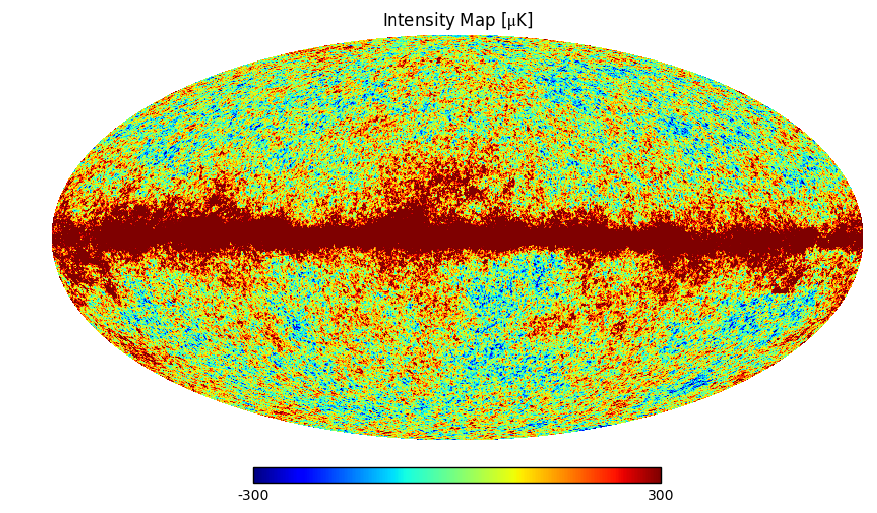

In [7]:
CMBmap = CMBmap0.copy()
plt.figure(0)
hp.mollview(CMBmap, xsize = 800, title = "$\mathregular{Intensity\ Map\ [\mu K]}$", min = -300, max =  300)
plt.show()

/Users/inchanji/anaconda/lib/python2.7/site-packages/healpy/pixelfunc.py:270: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/inchanji/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:2296: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/Users/inchanji/anaconda/lib/python2.7/site-packages/healpy/projaxes.py:998: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/inchanji/anaconda/lib/python2.7/site-packages/healpy/projaxes.py:999: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


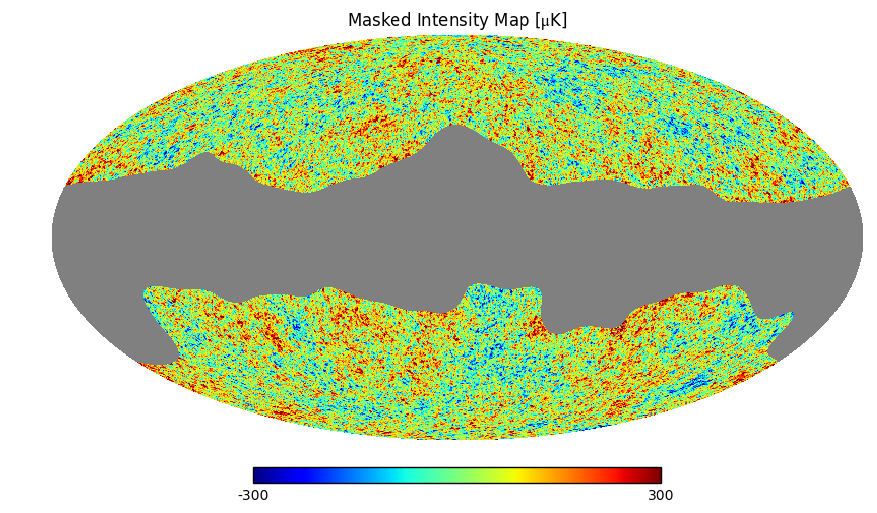

In [8]:
for i in range(len(GalMap)):
    if (GalMap[i] == 0.) or (PtMap[i] == 0.): CMBmap[i] = np.nan
plt.figure(0)
hp.mollview(CMBmap, xsize = 800, title = "$\mathregular{Masked\ Intensity\ Map\ [\mu K]}$", min = -300, max =  300)
plt.show()



In [10]:
CMBmap1 = CMBmap.copy()
ind = np.where(ind_gal)[0]
x = []; y = []; T = [];
for i in range(len(ind)):
    index = (np.abs(theta_ring - Catalog.theta[ind[i]]) < dtheta ) & (np.abs(phi_ring - Catalog.phi[ind[i]]) < dphi ) 

    index = np.where(index)[0]
    x.append(phi_ring[index])
    y.append(theta_ring[index])
    T.append(CMBmap1[index])

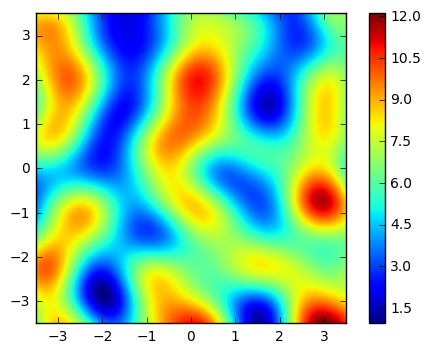

In [12]:
Nsize = 151 ; sig = 1.4 / 2.3548
x1d = np.linspace(-3.5,3.5, Nsize); y1d = np.linspace(-3.5,3.5, Nsize);
xres = yres = 3437.75 # 1 arcmin in radian
X, Y = np.meshgrid(x1d, y1d)


MapStack = np.zeros((Nsize, Nsize))
norm = np.sum(np.exp(-0.5 * ((X)**2. + (Y)**2.) / sig**2.  ) )

for i in range(len(ind)):
    for j in range(len(x[i])):
        if (T[i][j] > hp.UNSEEN) & np.isfinite(T[i][j]):
            dx = (x[i][j] - Catalog.phi[ind[i]])  * xres
            dy = (y[i][j] - Catalog.theta[ind[i]]) * yres
            #print dx, dy, T[i][j]
            MapStack += np.exp(-0.5 * ((X-dx)**2. + (Y-dy)**2.) / sig**2.  )  / (2. * np.pi * sig**2.) * T[i][j]
            #print T[i][j], dx, dy

#MapStack += np.exp(-0.5 * ((X-1)**2. + (Y-1)**2.) / sig**2.  )  * 100.
MapStack /= len(ind)

extent = (-3.5, 3.5, -3.5, 3.5)
plt.figure(0) 
plt.imshow(MapStack, origin='lower',zorder=0,extent = extent)
plt.colorbar()
plt.show()



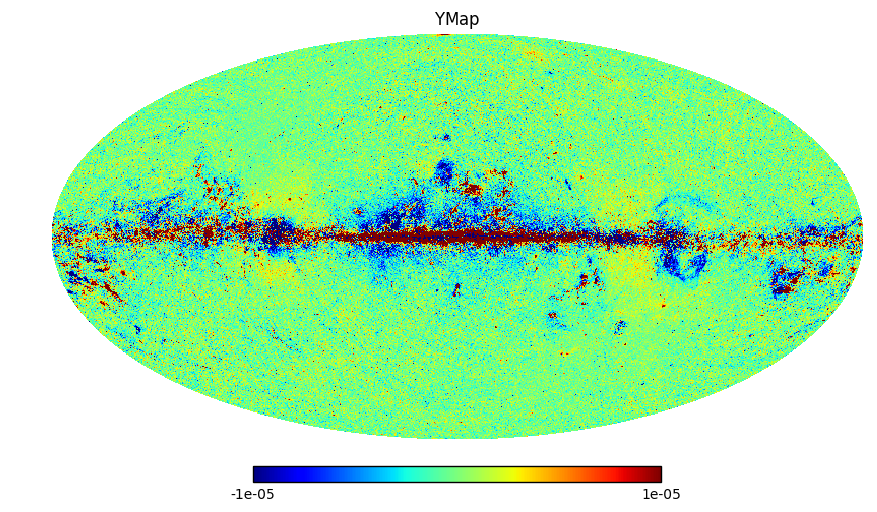

In [6]:
SZmap = SZmap0.copy()

#ind = ( phi_ring < 0.2)  & ( phi_ring > -0.2) & (theta_ring < 0.3)
#SZmap[ind] = 30000.

plt.figure(0)
hp.mollview(SZmap, xsize = 800, title = "$\mathregular{Y Map}$", min = -1e-5, max = 1e-5)
plt.show()

In [7]:
for i in range(len(SZForegroundMask)):
    if (SZForegroundMask[i] == 0.) or (SZPtMask[i] == 0.): SZmap[i] = np.nan


/Users/inchanji/anaconda/lib/python2.7/site-packages/healpy/pixelfunc.py:270: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/inchanji/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:2296: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/Users/inchanji/anaconda/lib/python2.7/site-packages/healpy/projaxes.py:998: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/inchanji/anaconda/lib/python2.7/site-packages/healpy/projaxes.py:999: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


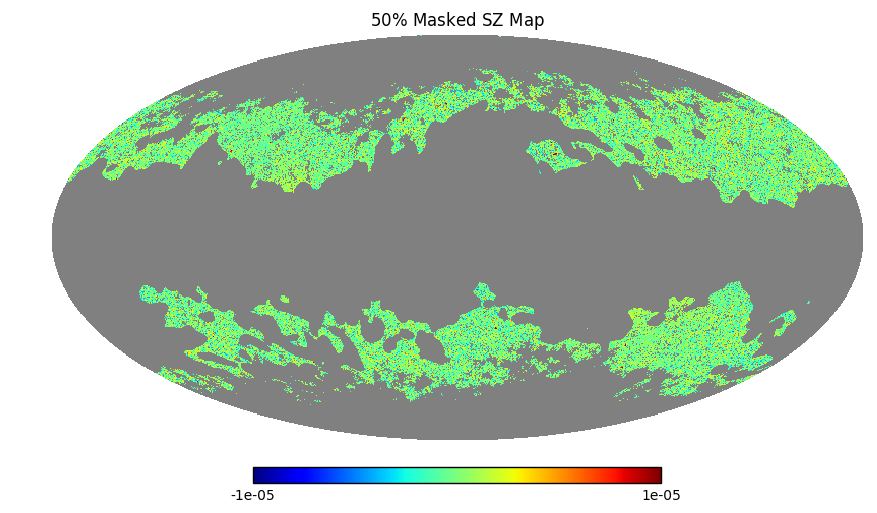

In [8]:
plt.figure(0)
hp.mollview(SZmap, xsize = 800, title = "$\mathregular{50\\%\ Masked\ SZ\ Map}$", min = -1e-5, max = 1e-5)
plt.show()

In [ ]:
massbin = np.logspace(11.5,12.,5)
dtheta = 0.000872664625998 ;# 3 arcmin

ymap = []
ymaperr = []
xmass = []

for n in range(1,len(massbin)):
    
    ind = (Catalog.MASS > massbin[n-1]) & (Catalog.MASS < massbin[n])
    cnt = np.sum(ind)
    print massbin[n-1], massbin[n] , cnt
    if cnt > 0:
        subymap = []; submass = []
        ind = np.where(ind)[0]
        if cnt > 100: 
            cnt = 100
            ind = pick_random_indice(index = ind, num = cnt)
        Ntot = cnt
        for i in range(cnt):
            stack = 0.; ncount = 0.;
            j = ind[i]
            submass.append(Catalog.MASS[j])
            theta = Catalog.theta[j]; phi = Catalog.phi[j]
            indcoord = (np.abs(theta_ring - theta) < dtheta) & (np.abs(phi_ring - phi) < dtheta)
            indcoord = np.where(indcoord)[0]
            Ncoord = np.sum(np.isfinite(SZmap[indcoord]))
            if Ncoord < 1:
                Ntot -= 1
                continue
            dssangle = 36. / Ncoord
            for k in range(len(indcoord)):
                if np.isfinite(SZmap[indcoord[k]]):
                    stack += SZmap[indcoord[k]] * dssangle
            subymap.append(stack)

        ymap.append(np.mean(subymap)); ymaperr.append(np.std(subymap)/np.sqrt(Ntot));
        xmass.append(np.mean(submass))




316227766017.0 421696503429.0 49


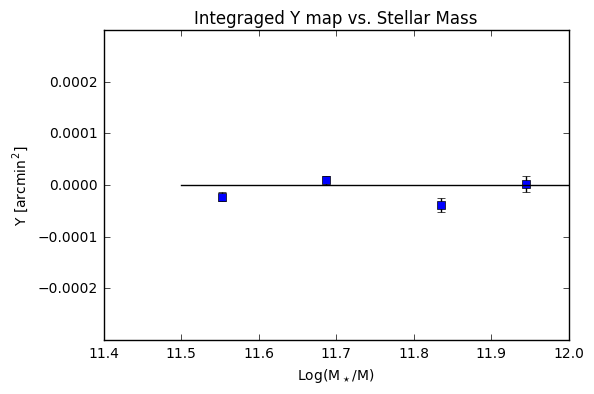

In [13]:
plt.errorbar(np.log10(xmass),ymap,yerr=ymaperr,fmt='bs',ecolor='k')
plt.ylim(-0.0003,0.0003)
plt.xlabel('$\mathregular{Log(M_\star/M)}$')
plt.ylabel('$\mathregular{Y\ [arcmin^2]}$')
plt.title('Integraged Y map vs. Stellar Mass')
plt.plot([11.5,12.],[0,0],'k-')
plt.show()